In [1]:
import src.service.get_data as av
import src.model.SplitData as sd
import src.model.WindowGenerator as wg
from src.model.WindowGenerator import WindowGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
API_KEY = "trail"
alpha_vantage = av.AlphaVantageAPI(API_KEY)
df = alpha_vantage.get_weekly_stock_prices("AAPL")

2025-02-24 06:23:01,114 - INFO - Calling URL: https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol=AAPL&apikey=trail&outputsize=full


In [3]:
split_data = sd.SplitData(df)

In [4]:
window = wg.WindowGenerator(input_width=120, label_width=5, shift=6, split_data=split_data, label_columns=['close'])
window

Total window size: 126
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [121 122 123 124 125]
Label column name(s): ['close']

In [5]:
# Stack three slices, the length of the total window.
example_window = tf.stack([
            np.array(split_data.train_df[:window.total_window_size]),
            np.array(split_data.train_df[100:100+window.total_window_size]),
            np.array(split_data.train_df[200:200+window.total_window_size])])

example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 126, 5)
Inputs shape: (3, 120, 5)
Labels shape: (3, 5, 1)


In [6]:
window.example = example_inputs, example_labels

In [7]:
def plot(self, model=None, plot_col='close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [week]')

WindowGenerator.plot = plot

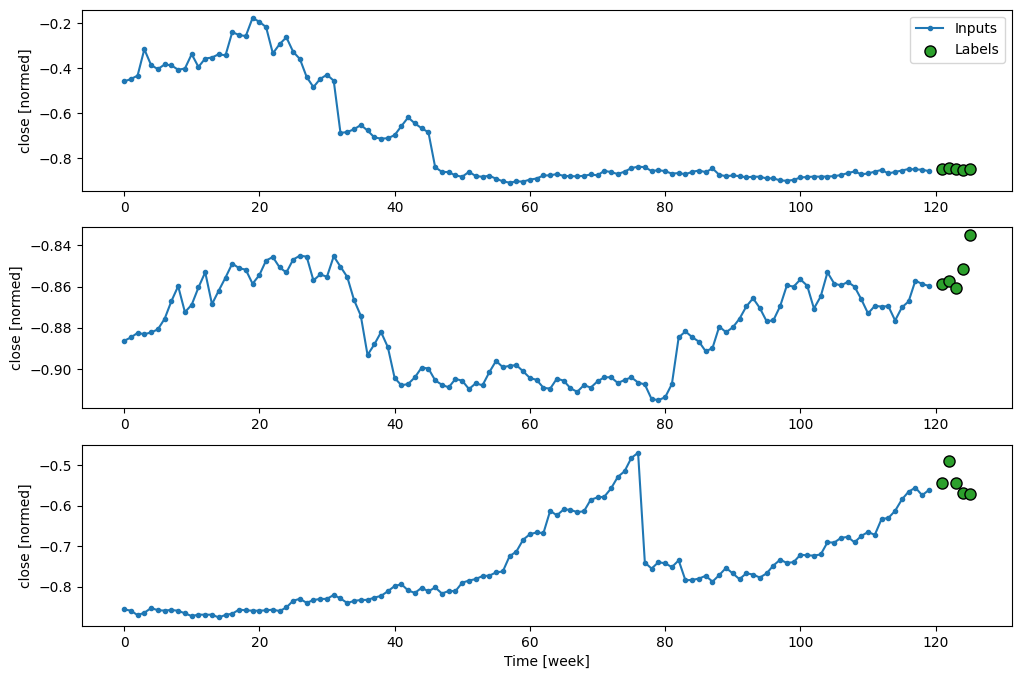

In [8]:
window.plot()

In [9]:
for example_inputs, example_labels in window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 120, 5)
Labels shape (batch, time, features): (32, 5, 1)


2025-02-24 06:23:03.021789: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,split_data=split_data,
    label_columns=['close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [12]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


2025-02-24 06:24:11.359305: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [15]:
baseline = Baseline(label_index=single_step_window.column_indices['close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - mean_absolute_error: 0.0407  
